# Sequential Testing vs T-Test

We compare two statistical methods for A/B testing, t-test and sequential testing. We first compare how each test performs by conducting a series of A/A tests to gauge their Type 1 errors and determine how well it's controlled.

## Data generation methods

Methods for generating visitors and running trials.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

### Set up color and plotting
current_palette = matplotlib.colors.hex2color('#99cfe0')

In [2]:
from datetime import datetime
from test import Test

def run_test_and_get_stats(test, conversion_rates, allocation_probs, num_visitors, peek_interval, stop_if_significant=True):
    
    # Keep track of test statistics
    test_stats = []

    total_visitors = 0
    control_events_sum = treatment_events_sum = 0
    control_num_units = treatment_num_units = 0
    
    start_date = datetime

    while total_visitors < num_visitors:    
        # Bucket visitor, observe outcome            
        total_visitors += 1
        assignment_val = np.random.rand() 
        for idx, p in enumerate(allocation_probs):
            assignment_val -= p 
            if assignment_val < 0:
                break
        outcome = np.random.binomial(n=1, p=conversion_rates[idx])

        if idx == 0:
            control_events_sum += outcome
            control_num_units += 1
        else:
            treatment_events_sum += outcome
            treatment_num_units += 1

        if total_visitors % peek_interval == 0:
            test.update(
                control_events_sum=control_events_sum,
                treatment_events_sum=treatment_events_sum,
                control_events_sos=control_events_sum,
                treatment_events_sos=treatment_events_sum,
                control_num_units=control_num_units,
                treatment_num_units=treatment_num_units)
            test_stats.append(test.to_dict())
            
            # reset for next peek
            control_events_sum = treatment_events_sum = 0
            control_num_units = treatment_num_units = 0
        
        # We won't record how often the test is accept/reject. We will note the first time it happens for counting purposes.
        if stop_if_significant and test.state != Test.State.CONTINUE: 
            break
    
    df = pd.DataFrame.from_dict([ts for ts in test_stats])
    return df

In [3]:
from binary_sequential_test import BinarySequentialTest
from t_test import TTest, Alternative

def analyze(num_trials, num_visitors, allocation_probs, conversion_rates, alpha, beta, sample_size, peek_interval, stop_if_significant=True, test_type='BinarySequentialTest'):
    num_reject = 0
    dfs = []
    for i in range(num_trials):
        if test_type == 'BinarySequentialTest':
            test = BinarySequentialTest(alpha=alpha, beta=beta, sample_size=sample_size)
        elif test_type == 'TTest':
            test = TTest(alpha, beta, alternative=Alternative.TWO_SIDED)
        else:
            raise ValueError("Test type not supported")
            
        df = run_test_and_get_stats(test, conversion_rates, allocation_probs, num_visitors, peek_interval, stop_if_significant)
        dfs.append(df)
    
    return dfs

---
## T-Test
In general, t-tests are a common approach to A/B testing, but can be incorrectly applied when continuously monitoring your results, especially when running digital experiments. This is commonly known as peeking. It's no surprise that someone may be compelled to end their A/B test prematurely if the results look statistically significant.  

### Type 1 Error
Run 100 trials of A/A Tests for each configuration

In [4]:
import numpy as np
import pandas as pd

NUM_TRIALS = 100
NUM_VISITORS = 10000

# Parameters for A/B testing
alpha = 0.05
beta = 0.2
delta_true = 0.0 # true effect size (absolute) between control and treatment
baselines = [0.01, 0.05, 0.1, 0.2]

# Traffic Allocation
num_variations = 2
allocation_probs = [0.5, 0.5]

aa_tests = []
for baseline in baselines:
    conversion_rates = [baseline, baseline + delta_true]
    print("===Running A/A Test for baseline {}, delta_true {}===".format(baseline, delta_true))
    dfs = analyze(NUM_TRIALS, NUM_VISITORS, allocation_probs, conversion_rates, alpha, beta, sample_size=None, peek_interval=50, test_type='TTest')

    # For the trials that were rejected, get the p-values and times of rejection. 
    rej_pvals_dfs = [
        df.loc[df['p_value'] < alpha][['p_value', 'total_units']]
        for df in dfs if not df.loc[df['p_value'] < alpha].empty
    ]
    rej_pvals_df = pd.concat(rej_pvals_dfs) if len(rej_pvals_dfs) > 0 else pd.DataFrame()
    
    results = {
        'alpha': alpha,
        'beta': beta,
        'baseline': baseline,
        'delta_true': delta_true,
        'num_reject': rej_pvals_df.shape[0],
    }
    aa_tests.append(results)

aa_df = pd.DataFrame.from_dict([test for test in aa_tests])

===Running A/A Test for baseline 0.01, delta_true 0.0===
===Running A/A Test for baseline 0.05, delta_true 0.0===
===Running A/A Test for baseline 0.1, delta_true 0.0===
===Running A/A Test for baseline 0.2, delta_true 0.0===


In [5]:
aa_df

,alpha,beta,baseline,delta_true,num_reject
0,0.05,0.2,0.01,0.0,22
1,0.05,0.2,0.05,0.0,31
2,0.05,0.2,0.10,0.0,32
3,0.05,0.2,0.20,0.0,36


### Plotting p-values over time

Text(0.5, 1.0, 'Binary Sequential Testing (alpha = 0.05)')

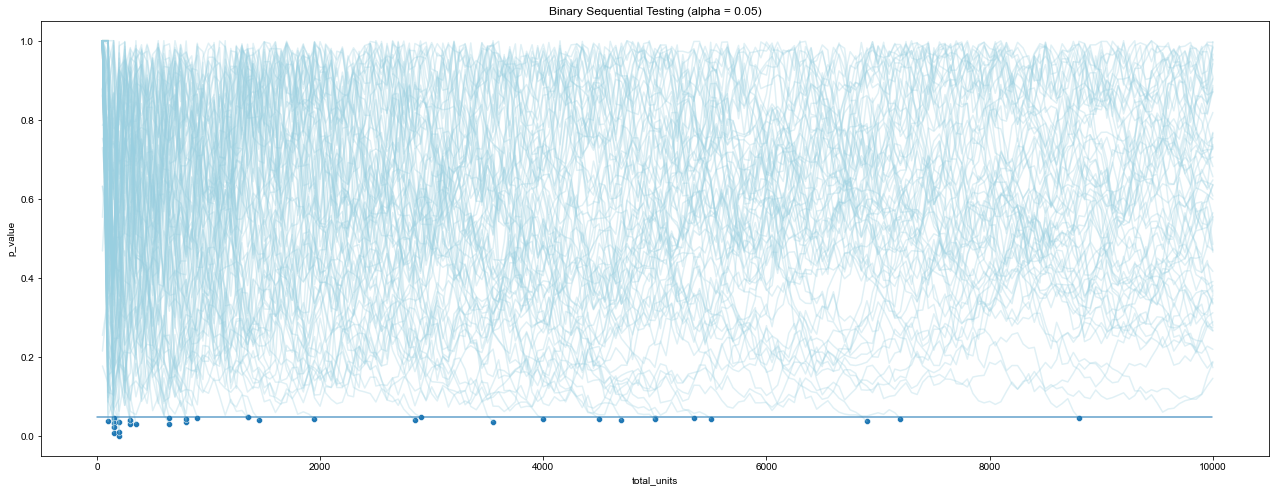

In [6]:
### Set up color and plotting
fig, ax = plt.subplots(figsize=(22, 8))
sns.set_theme(style="darkgrid")
current_palette = matplotlib.colors.hex2color('#99cfe0')

for i in range(100):
    sns.lineplot(x='total_units', y='p_value', color=current_palette, data=dfs[i], legend=False, ax=ax, alpha=0.3)
sns.lineplot(x='total_units', y='alpha', data=pd.DataFrame({'total_units': range(0, 10000, 10), 'alpha': np.ones((1000,)) * alpha}), ax=ax, alpha=0.7)
if not rej_pvals_df.empty:
    sns.scatterplot(x='total_units', y='p_value', data=rej_pvals_df, legend=False, ax=ax)
ax.set_title('Binary Sequential Testing (alpha = 0.05)')

### Conclusion

The p-values for each of the 100 trials are plotted above, with the p-values that go below alpha clearly marked. We can see that the p-values fluctuate wildly indicating that Type 1 error isn't controlled during the duration of an experiment. 

With alpha = 0.05, we expect the number of rejects to be controlled below this threshold. However, if we continuously monitor our results we would be susceptible to peeking, concluding our test **right when we see** the p-value dip below alpha. As a result, this inflates our Type 1 error well beyond the predetermined alpha to as much as 40%!

Considering this pitfall we wanted to ensure that we could still monitor our results in a reliable manner so we considered sequential testing using mSPRT. 

----

## Sequential Testing

### Type 1 Error

**Run N trials of A/A Tests**

In [7]:
import numpy as np
import pandas as pd

NUM_TRIALS = 100
NUM_VISITORS = 10000

# Parameters for A/B testing
alpha = 0.05
beta = 0.2
delta_true = 0.0 # true effect size (absolute) between control and treatment
baselines = [0.01, 0.05, 0.1, 0.2]

# Traffic Allocation
num_variations = 2
allocation_probs = [0.5, 0.5]

aa_tests = []
for baseline in baselines:
    conversion_rates = [baseline, baseline + delta_true]
    print("===Running A/A Test for baseline {}, delta_true {}===".format(baseline, delta_true))
    dfs = analyze(NUM_TRIALS, NUM_VISITORS, allocation_probs, conversion_rates, alpha, beta, sample_size=None, peek_interval=30, test_type='BinarySequentialTest')

    # For the trials that were rejected, get the p-values and times of rejection. 
    rej_pvals_dfs = [
        df.loc[df['p_value'] < alpha][['p_value', 'total_units']]
        for df in dfs if not df.loc[df['p_value'] < alpha].empty
    ]
    rej_pvals_df = pd.concat(rej_pvals_dfs) if len(rej_pvals_dfs) > 0 else pd.DataFrame()
    
    results = {
        'alpha': alpha,
        'beta': beta,
        'baseline': baseline,
        'delta_true': delta_true,
        'num_reject': rej_pvals_df.shape[0],
    }
    aa_tests.append(results)

aa_df = pd.DataFrame.from_dict([test for test in aa_tests])

===Running A/A Test for baseline 0.01, delta_true 0.0===
===Running A/A Test for baseline 0.05, delta_true 0.0===
===Running A/A Test for baseline 0.1, delta_true 0.0===
===Running A/A Test for baseline 0.2, delta_true 0.0===


**Plot the number of rejected A/A tests for different test configurations**

In [8]:
aa_df

,alpha,beta,baseline,delta_true,num_reject
0,0.05,0.2,0.01,0.0,1
1,0.05,0.2,0.05,0.0,2
2,0.05,0.2,0.10,0.0,1
3,0.05,0.2,0.20,0.0,0


Here we see that Type 1 error is indeed controlled below our threshold of alpha = 0.05, and we can confidently conclude our A/B tests reliably without inflating Type 1 error.

**Plotting p-values over time**

Text(0.5, 1.0, 'Binary Sequential Testing (alpha = 0.05)')

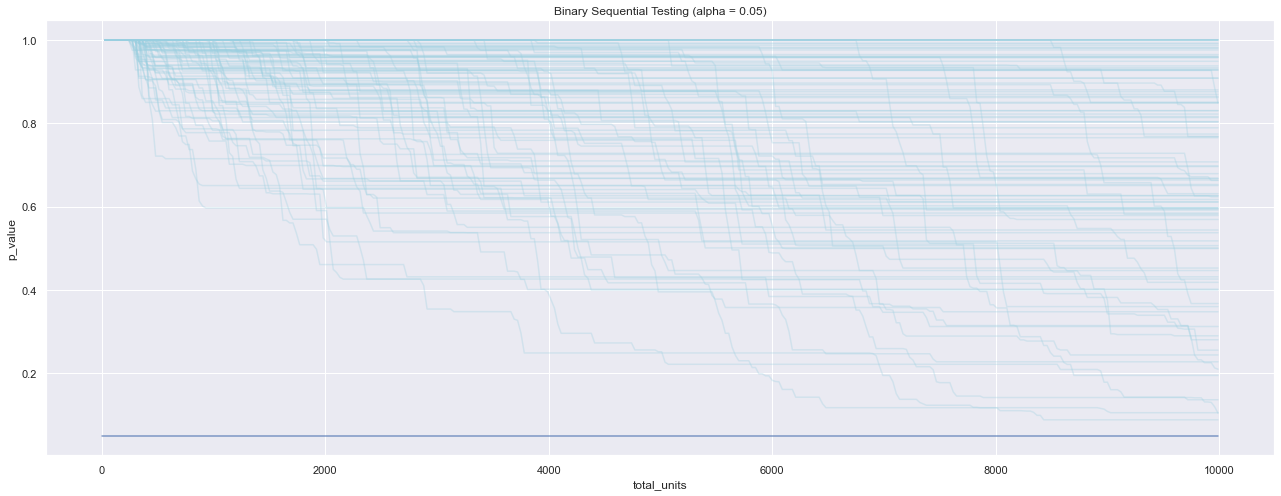

In [9]:
### Set up color and plotting
fig, ax = plt.subplots(figsize=(22, 8))
sns.set_theme(style="darkgrid")
current_palette = matplotlib.colors.hex2color('#99cfe0')

for i in range(100):
    sns.lineplot(x='total_units', y='p_value', color=current_palette, data=dfs[i], legend=False, ax=ax, alpha=0.3)
sns.lineplot(x='total_units', y='alpha', data=pd.DataFrame({'total_units': range(0, 10000, 10), 'alpha': np.ones((1000,)) * alpha}), ax=ax, alpha=0.7)
if not rej_pvals_df.empty:
    sns.scatterplot(x='total_units', y='p_value', data=rej_pvals_df, legend=False, ax=ax)
ax.set_title('Binary Sequential Testing (alpha = 0.05)')

#### Conclusion

Compared with the graph of the p-values for the t-test above, we see that Type 1 error doesn't exceed alpha throughout the whole process. **These merits are what compel us to use sequential testing because of this guarantee.** Now we'll look at how sequential testing fares when there is indeed an effect.

### Type 2 Error

**Run A/B tests**

In [10]:
import numpy as np
import pandas as pd

NUM_TRIALS = 100
NUM_VISITORS = 100000 # number of visitors

# Parameters for A/B testing
alpha = 0.05
beta = 0.2
delta_trues = [0.005, 0.01, 0.02] # true effect size (absolute) between control and treatment
baselines = [0.1, 0.2]

# Traffic Allocation
num_variations = 2
allocation_probs = [0.5, 0.5]

ab_tests = []
for baseline in baselines:
    for delta_true in delta_trues:
        conversion_rates = [baseline, baseline + delta_true]
        print("===Running A/B Test for baseline {}, delta_true {}===".format(baseline, delta_true))
        dfs = analyze(NUM_TRIALS, NUM_VISITORS, allocation_probs, conversion_rates, alpha, beta, sample_size=None, peek_interval=100, stop_if_significant=True)
        # For the trials that were rejected, get the p-values and times of rejection. 
        rej_pvals_dfs = [
            df.loc[df['p_value'] < alpha][['p_value', 'total_units']]
            for df in dfs if not df.loc[df['p_value'] < alpha].empty
        ]
        rej_pvals_df = pd.concat(rej_pvals_dfs) if len(rej_pvals_dfs) > 0 else pd.DataFrame()
        results = {
            'alpha': alpha,
            'beta': beta,
            'baseline': baseline,
            'delta_true': delta_true,
            'num_reject': rej_pvals_df.shape[0],
        }
        ab_tests.append(results)

ab_df = pd.DataFrame.from_dict([test for test in ab_tests])

===Running A/B Test for baseline 0.1, delta_true 0.005===
===Running A/B Test for baseline 0.1, delta_true 0.01===
===Running A/B Test for baseline 0.1, delta_true 0.02===
===Running A/B Test for baseline 0.2, delta_true 0.005===
===Running A/B Test for baseline 0.2, delta_true 0.01===
===Running A/B Test for baseline 0.2, delta_true 0.02===


In [11]:
ab_df

,alpha,beta,baseline,delta_true,num_reject
0,0.05,0.2,0.1,0.005,52
1,0.05,0.2,0.1,0.010,100
2,0.05,0.2,0.1,0.020,100
3,0.05,0.2,0.2,0.005,28
4,0.05,0.2,0.2,0.010,87
5,0.05,0.2,0.2,0.020,100


We observe that sequential testing is able to detect a wide range of effect sizes. Even for smaller effect sizes we know it will detect the effect given enough time, so we increase our max number of visitors below from 100K to 1M. 

In [12]:
import numpy as np
import pandas as pd

NUM_TRIALS = 100
NUM_VISITORS = 1000000 # number of visitors

# Parameters for A/B testing
alpha = 0.05
beta = 0.2
delta_trues = [0.005] # true effect size (absolute) between control and treatment
baselines = [0.1, 0.2]

# Traffic Allocation
num_variations = 2
allocation_probs = [0.5, 0.5]

ab_tests = []
for baseline in baselines:
    for delta_true in delta_trues:
        conversion_rates = [baseline, baseline + delta_true]
        print("===Running A/B Test for baseline {}, delta_true {}===".format(baseline, delta_true))
        dfs = analyze(NUM_TRIALS, NUM_VISITORS, allocation_probs, conversion_rates, alpha, beta, sample_size=None, peek_interval=100, stop_if_significant=True)
        # For the trials that were rejected, get the p-values and times of rejection. 
        rej_pvals_dfs = [
            df.loc[df['p_value'] < alpha][['p_value', 'total_units']]
            for df in dfs if not df.loc[df['p_value'] < alpha].empty
        ]
        rej_pvals_df = pd.concat(rej_pvals_dfs) if len(rej_pvals_dfs) > 0 else pd.DataFrame()
        results = {
            'alpha': alpha,
            'beta': beta,
            'baseline': baseline,
            'delta_true': delta_true,
            'num_reject': rej_pvals_df.shape[0],
        }
        ab_tests.append(results)

ab_df = pd.DataFrame.from_dict([test for test in ab_tests])

===Running A/B Test for baseline 0.1, delta_true 0.005===
===Running A/B Test for baseline 0.2, delta_true 0.005===


In [13]:
ab_df

,alpha,beta,baseline,delta_true,num_reject
0,0.05,0.2,0.1,0.005,100
1,0.05,0.2,0.2,0.005,100


Indeed, we do see that the effect size is detected. This kind of sequential testing has power 1 in detecting effects if one exists; the matter now becomes whether the user is willing to wait long enough to detect the difference.

#### Plotting p-values over time
Below we plot the p-values for the latest configuration setting we have from our simulations (alpha = 0.05, baseline = 0.2, delta_true = 0.02)

Text(0.5, 1.0, 'Binary Sequential Testing (alpha = 0.05)')

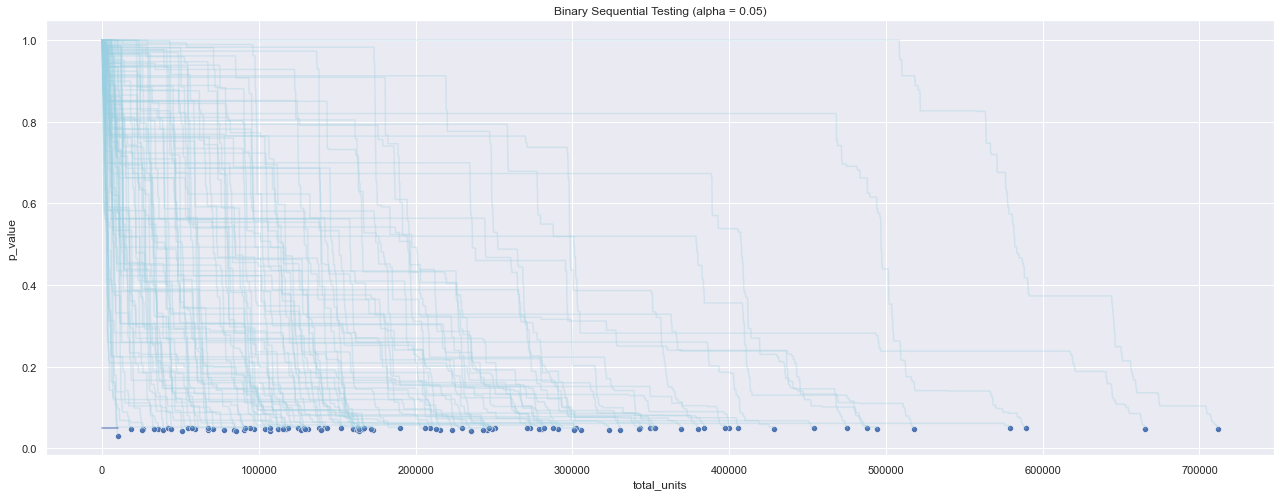

In [14]:
### Set up color and plotting
fig, ax = plt.subplots(figsize=(22, 8))
sns.set_theme(style="darkgrid")
current_palette = matplotlib.colors.hex2color('#99cfe0')

for i in range(100):
    sns.lineplot(x='total_units', y='p_value', color=current_palette, data=dfs[i], legend=False, ax=ax, alpha=0.3)
sns.lineplot(x='total_units', y='alpha', data=pd.DataFrame({'total_units': range(0, 10000, 10), 'alpha': np.ones((1000,)) * alpha}), ax=ax, alpha=0.7)
if not rej_pvals_df.empty:
    sns.scatterplot(x='total_units', y='p_value', data=rej_pvals_df, legend=False, ax=ax)
ax.set_title('Binary Sequential Testing (alpha = 0.05)')

#### Inspecting confidence interval and p-value for one trial.

We see that the confidence interval no longer contains 0 which also occurs when p-value goes below alpha.

Text(0.5, 1.0, 'Baseline = 0.2, Delta_true = 0.005')

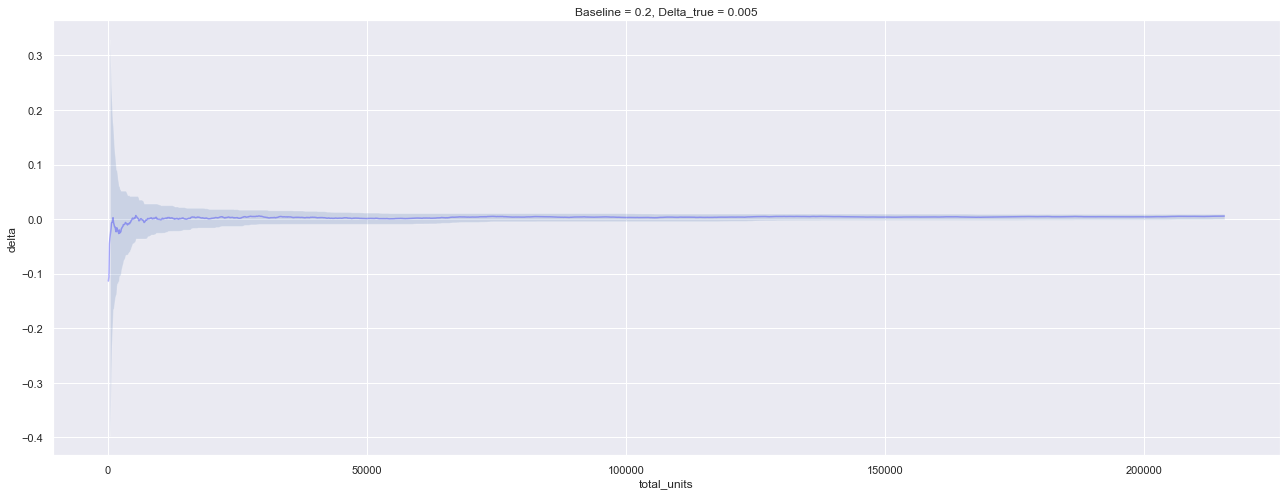

In [15]:
# ### Set up color and plotting
# fig, ax = plt.subplots(figsize=(22, 8))
# sns.set_theme(style="darkgrid")
# current_palette = matplotlib.colors.hex2color('#99cfe0')

fig, ax = plt.subplots(figsize=(22, 8))
sns.set_theme(style="darkgrid")
sns.lineplot(x='total_units', y='delta', color='blue', data=dfs[0], legend=False, ax=ax, alpha=0.3)
ax.fill_between(dfs[0]['total_units'], dfs[0]['lower_confidence_interval'], dfs[0]['upper_confidence_interval'], alpha=0.2)
ax.set_title('Baseline = {}, Delta_true = {}'.format(baseline, delta_true))

Text(0.5, 1.0, 'Baseline = 0.2, Delta_true = 0.005')

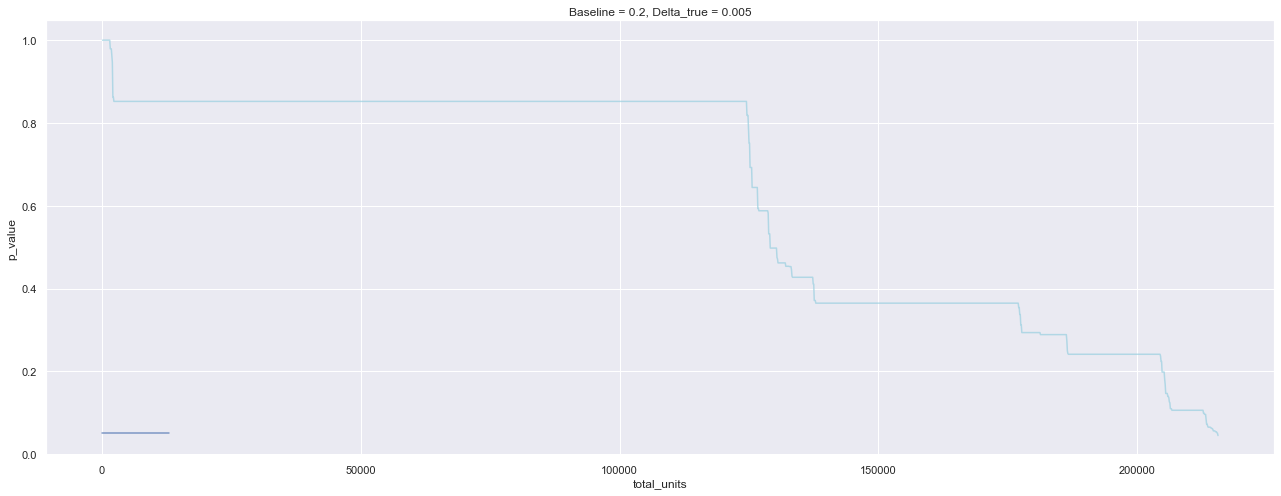

In [16]:
fig, ax = plt.subplots(figsize=(22, 8))
sns.set_theme(style="darkgrid")
sns.lineplot(x='total_units', y='p_value', color=current_palette, data=dfs[0], legend=False, ax=ax, alpha=0.7)
sns.lineplot(x='total_units', y='alpha', data=pd.DataFrame({'total_units': range(0, 13000, 100), 'alpha': np.ones((130,)) * alpha}), ax=ax, alpha=0.7)
ax.set_title('Baseline = {}, Delta_true = {}'.format(baseline, delta_true))